In [1]:
#tensorflow 버전 확인
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
# GPU 사용하는 경우, device list에 GPU 있는지 확인
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6275398496062487145
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7799308288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3014703086911239912
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
#필요한 모듈 불러오기
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification,utils

# attention mask 시각화를 위한 모듈
from bertviz import model_view
utils.logging.set_verbosity_error()

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

from tabulate import tabulate
from tqdm import trange
import random
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


print("GPU available:",torch.cuda.is_available())

GPU available: True


In [7]:
def printNpRatio(df):
    neg = len(df[df['polarity'] == 0])
    pos=len(df[df['polarity'] == 1])
    print("positive: {}, negative: {}".format(pos,neg))
    print("positive {:.4f}, negative {:.4f}".format(pos/(pos+neg),neg/(pos+neg)))
    
def printLenStat(df,colName):
    lendf = pd.DataFrame()
    lendf['length'] = df[colName].apply(len)
    print(lendf.length.describe())

In [8]:
# data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
# Price 속성 리뷰
url='./data/price_total.csv'
df = pd.read_csv(url,sep=',', header=0, encoding_errors='ignore')
df.head(5)

,id,text,category,polarity
0,1476493:3,"When you add it all together, it just doesn't ...",price,0
1,2156,The bagels are also reasonably priced for NYC.,price,1
2,2424,"It's true, this place is not cheap.",price,0
3,Z#3:2,"I paid just about $60 for a good meal, though :)",price,1
4,2645,BUt their best dish is thh Thai spiced curry n...,price,1


In [9]:
printNpRatio(df)
print()
printLenStat(df,'text')

positive: 216, negative: 184
positive 0.5400, negative 0.4600

count    400.000000
mean      79.477500
std       47.393616
min        6.000000
25%       47.000000
50%       70.000000
75%      102.000000
max      370.000000
Name: length, dtype: float64


In [10]:
text = df.text.values
labels = df.polarity.values

In [11]:
# 전처리를 위한 tokenizer 불러오기
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [12]:
#전처리
MAX_LENGTH=150
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer,max_len_input=MAX_LENGTH):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = max_len_input,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)

  # token_id 리스트 추출
  token_id.append(encoding_dict['input_ids']) 
  # attention_mask 리스트 추출
  attention_masks.append(encoding_dict['attention_mask'])


# 리스트를 텐서로
token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

In [13]:
#데이터 train set, validation set 분리
VAL_RATIO= 0.2
batch_size = 8 

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = VAL_RATIO,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )


print("train: {}".format(len(train_idx)))
print("validation: {}".format(len(val_idx)))


train: 320
validation: 80


In [14]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])


def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N

  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)

  return b_accuracy

In [15]:
# BERT 모델 불러오기
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = True,
    output_hidden_states = False,
)


optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5, # learning rate 설정
                              eps = 1e-08
                              )


# GPU 확인 및 할당
if torch.cuda.is_available():
    device=torch.device('cuda')
    print("GPU available.")
else:
    device=torch.device("cpu")
    print("No GPU available, using CPU instead.")


#model.cuda()
model.to(device)

GPU available.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [16]:
# GPU로 학습하도록 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 학습 횟수 설정
epochs = 15

idx=0
epo_list=[]
train_loss_list=[]
val_accuracy_list=[]

for _ in trange(epochs, desc = 'Epoch'):
    idx+=1
    epo_list.append(idx)

    # ========== Training ==========
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        
        

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    val_accuracy_temp=sum(val_accuracy)/len(val_accuracy)
    train_loss_list.append(round(tr_loss / nb_tr_steps,4))
    val_accuracy_list.append(round(val_accuracy_temp,4))

Epoch:   7%|█████                                                                       | 1/15 [00:08<02:03,  8.80s/it]


	 - Train loss: 0.6689
	 - Validation Accuracy: 0.8125


Epoch:  13%|██████████▏                                                                 | 2/15 [00:11<01:11,  5.50s/it]


	 - Train loss: 0.4773
	 - Validation Accuracy: 0.8500


Epoch:  20%|███████████████▏                                                            | 3/15 [00:14<00:52,  4.34s/it]


	 - Train loss: 0.1732
	 - Validation Accuracy: 0.8500


Epoch:  27%|████████████████████▎                                                       | 4/15 [00:17<00:41,  3.80s/it]


	 - Train loss: 0.0631
	 - Validation Accuracy: 0.9000


Epoch:  33%|█████████████████████████▎                                                  | 5/15 [00:20<00:35,  3.54s/it]


	 - Train loss: 0.0346
	 - Validation Accuracy: 0.8125


Epoch:  40%|██████████████████████████████▍                                             | 6/15 [00:23<00:30,  3.36s/it]


	 - Train loss: 0.1061
	 - Validation Accuracy: 0.8500


Epoch:  47%|███████████████████████████████████▍                                        | 7/15 [00:26<00:25,  3.23s/it]


	 - Train loss: 0.0514
	 - Validation Accuracy: 0.8375


Epoch:  53%|████████████████████████████████████████▌                                   | 8/15 [00:30<00:22,  3.18s/it]


	 - Train loss: 0.0399
	 - Validation Accuracy: 0.8375


Epoch:  60%|█████████████████████████████████████████████▌                              | 9/15 [00:33<00:18,  3.13s/it]


	 - Train loss: 0.0408
	 - Validation Accuracy: 0.8375


Epoch:  67%|██████████████████████████████████████████████████                         | 10/15 [00:36<00:15,  3.10s/it]


	 - Train loss: 0.0273
	 - Validation Accuracy: 0.8875


Epoch:  73%|██████████████████████████████████████████████████████▉                    | 11/15 [00:39<00:12,  3.07s/it]


	 - Train loss: 0.0124
	 - Validation Accuracy: 0.8750


Epoch:  80%|████████████████████████████████████████████████████████████               | 12/15 [00:42<00:09,  3.06s/it]


	 - Train loss: 0.0071
	 - Validation Accuracy: 0.8750


Epoch:  87%|█████████████████████████████████████████████████████████████████          | 13/15 [00:45<00:06,  3.05s/it]


	 - Train loss: 0.0053
	 - Validation Accuracy: 0.8625


Epoch:  93%|██████████████████████████████████████████████████████████████████████     | 14/15 [00:48<00:03,  3.03s/it]


	 - Train loss: 0.0048
	 - Validation Accuracy: 0.8625


Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 15/15 [00:51<00:00,  3.41s/it]


	 - Train loss: 0.0057
	 - Validation Accuracy: 0.8750


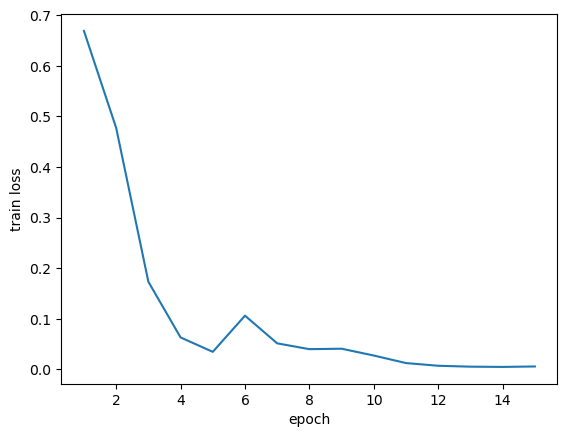

In [17]:
# train loss 그래프
plt.plot(epo_list, train_loss_list)
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show()

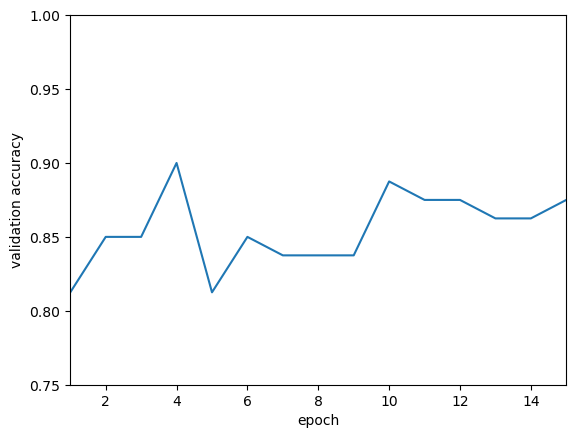

In [18]:
#validation accuracy 그래프
plt.plot(epo_list, val_accuracy_list)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.axis([1,epochs , 0.75, 1])
plt.show()

In [19]:
#새로운 리뷰를 분류해보자

def test_sentence(sentence):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []

    # 전처리
    encoding = preprocessing(sentence, tokenizer)
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

    prediction = 'Positive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    return prediction
    

    
    
new_sentence ='The food was bad, but it was cheap'
# 'It''s good, but the owner is so unkind. Some of the plates didn''t clean properly because there was something on them. But it''s cost-effective.'

print('입력 문장:', new_sentence)
print('분류:', test_sentence(new_sentence))

입력 문장: The food was bad, but it was cheap
분류: Negative


In [20]:
def testAccuracy(text,labels):
    count=0
    wrongResult=[] # [[String text,Boolean prediction ], ... ]
    rightResult=[] # [[String text,Boolean prediction ], ... ]

    for i in range(len(labels)):
        t = text[i]
        color_s='\033[31m' 
        color_e='\033[0m'
    
        prediction=test_sentence(t)
        if(prediction=="Negative"):
            result=0
        else:
            result=1
        
        if(result==labels[i]):
            count+=1     
            color_s=''
            color_e=''
            rightResult.append([t,1 if prediction=="Positive" else 0])
        else:
            wrongResult.append([t,1 if prediction=="Positive" else 0])
        print(color_s+"=============================== Input {} ===============================".format(i+1))
        print(t)
        print("model result:",prediction,"\nanswer:", labels[i],color_e)
        print("")


    print("test accuracy: {:.4f}".format(count/len(labels)))
    return rightResult,wrongResult

In [21]:
# 개별 문장의 attention 추출하는 함수
def get_attention(encoding):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        model_output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))
        
    prediction = 'Positive' if np.argmax(model_output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    attention=model_output[-1]
    last_attention=attention[-1]
    tokens=tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    
    return attention,last_attention,tokens,prediction

In [22]:
def get_val_len(ids):
    count=0
    for elem in ids:
        if(elem!=0):
            count+=1
    return count

In [23]:
def sort_by_att(attention,tokens):
    '''
        last layer의 attention tensor를 입력 받아 각 token의 attention 값을 head에 대한 평균을 낸 뒤, attention이 높은 token 순으로 idx를 반환하는 함수
    '''
    
    attention=attention[0] # shape: 12,len,len
    
    size=len(tokens)
    
    total_atts_sum=[] # 각 head에 대한 각 토큰의 attention값의 합
    for head in range(0,12):
        att_of_head=attention[head] # 한 head의 attention
        atts_sum_of_head=[0.0]*size # 해당 head 하나의 attention의 합
        for row in att_of_head:
            col=0
            for elem in row:
                value=elem.item()
                atts_sum_of_head[col]+=value # head 하나에 대한 토큰이 가지는 attention 값
                col+=1
        total_atts_sum.append(atts_sum_of_head)
    
    total_sum_value=[0.0]*size
    for elem in total_atts_sum:
        for i in range(0,size):
            total_sum_value[i]+=elem[i]
            

    total_mean=[]
    for elem in total_sum_value:
        total_mean.append(elem/12)
    
    


    idxs=sorted(range(len(total_mean)), key=lambda k: total_mean[k], reverse=True)
    return(idxs)
    

In [24]:
# attention 순서대로 텍스트 배경색 주기
color_code=[
    "\033[48;5;243m",
    "\033[48;5;245m",
    "\033[48;5;247m",
    "\033[48;5;249m",
    "\033[48;5;251m",
    "\033[48;5;253m",
    "\033[48;5;255m"
]
def emp_by_att(attIdxs,tokens):   
    valTokens=[]
    for tok in tokens:
        if(tok!='[CLS]' and tok!='[PAD]' and tok!='[SEP]'):
            valTokens.append(tok)
        
    valIdxs=[]
    for idx in attIdxs:
        if len(valIdxs)==7:
            break;
        
        if(idx>0 and idx<=len(valTokens)):
            if(valTokens[idx-1]!=',' and valTokens[idx-1]!='.'):
                valIdxs.append(idx-1)
    
    resultSent=""
    for i in range(len(valTokens)):
        if(i in valIdxs):
            outTok=color_code[valIdxs.index(i)]+valTokens[i]+"\033[0m"
        else:
            outTok=valTokens[i]
        resultSent+=outTok
        resultSent+=' '
    
    print("========================= emphasize by attention result==========================")
    print(resultSent)

In [25]:
def get_highest_att_tok(idxs,retTok,num):
    count=0
    print("highest attention: ",end="")
    for i in idxs:
        if(i<len(retTok)):
            if(retTok[i]!='[CLS]' and retTok[i]!='[SEP]' and retTok[i]!='.' and retTok[i]!=','):
                if(count<num):
                    print(retTok[i],end=" ")
                    count+=1
                

In [26]:
def empSentByAtt(sent,length,high):
    encoding = preprocessing(sent, tokenizer,length)
    
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])
    print('MAX_LEN: ',MAX_LEN_IN)
    
    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)
    idxs=sort_by_att(retLastAtt,retTok)
    emp_by_att(idxs,retTok)
    get_highest_att_tok(idxs,retTok,high)

In [27]:
#test data 세팅

# data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/price_test.csv'
test_df = pd.read_csv(test_url,sep=',', header=0, encoding_errors='ignore')
test_df.head(5)

,id,text,category,polarity
0,en_SnoozeanAMEatery_480171723:7,The pancakes were certainly inventive but $8.5...,price,0
1,32899414#512291#3,Cuisine is billed as asian fusion - doesn't me...,price,0
2,13383936#420974#1,I found the food to be just as good as its own...,price,1
3,11538980#1053497#4,But make sure you have enough room on your cre...,price,0
4,32889544#0#0,A mix of students and area residents crowd int...,price,1


In [28]:
printNpRatio(test_df)
print()
printLenStat(test_df,'text')

positive: 50, negative: 50
positive 0.5000, negative 0.5000

count    100.000000
mean      79.860000
std       46.597355
min       10.000000
25%       48.750000
50%       69.000000
75%       98.250000
max      300.000000
Name: length, dtype: float64


In [29]:
test_text = test_df.text.values
test_labels = test_df.polarity.values

rightResult,wrongResult=testAccuracy(test_text,test_labels)
    

=============================== Input 1 ===============================
The pancakes were certainly inventive but $8.50 for 3 - 6" pancakes (one of them was more like 5") in the pancake flight (sample of 3 different pancakes) is well over-priced.
model result: Negative 
answer: 0 

=============================== Input 2 ===============================
Cuisine is billed as asian fusion - doesn't meet the bill.
model result: Negative 
answer: 0 

=============================== Input 3 ===============================
I found the food to be just as good as its owner, Da Silvano, just much less expensive.
model result: Negative 
answer: 1 

=============================== Input 4 ===============================
But make sure you have enough room on your credit card as the bill will leave a big dent in your wallet.
model result: Negative 
answer: 0 

=============================== Input 5 ===============================
A mix of students and area residents crowd into this narrow, barely t

=============================== Input 43 ===============================
Everything is very cheap.
model result: Positive 
answer: 1 

=============================== Input 44 ===============================
– Pretty cheap for sit down Mexican AND downtown.
model result: Positive 
answer: 1 

=============================== Input 45 ===============================
The sushi is reasonably priced and fresh.
model result: Positive 
answer: 1 

=============================== Input 46 ===============================
) It's not the best Japanese restaurant in the East Village, but it's a pretty solid one for its modest prices, and worth repeat visits.
model result: Positive 
answer: 1 

=============================== Input 47 ===============================
– As with most restaurants in Seattle, Mioposto's service was bad and the food was overpriced.
model result: Negative 
answer: 0 

=============================== Input 48 ===============================
The staff is arrogant, the price

In [30]:
#잘못 분류된 문장의 attention
for elem in wrongResult: # [[String text,Boolean prediction ], ... ]
    print('입력 문장:', elem[0]) 
    print('분류:', elem[1])

    empSentByAtt(elem[0],50,5)

    print()
    print()
    print()
    print()

입력 문장: I found the food to be just as good as its owner, Da Silvano, just much less expensive.
분류: 0
MAX_LEN:  24
========================= emphasize by attention result==========================
i found the food to be just as good as its owner , da silva ##no , just much less expensive . 
highest attention: food expensive i da just 



입력 문장: Anywhere else, the prices would be 3x as high!
분류: 0
MAX_LEN:  14
========================= emphasize by attention result==========================
anywhere else , the prices would be 3 ##x as high ! 
highest attention: prices ! high would ##x 



입력 문장: – The sushi here is perfectly good, but for $5 a piece, either the slices of fish should be larger, or there should be no pretense that this is a moderately priced restaurant (even for NYC).
분류: 1
MAX_LEN:  48
========================= emphasize by attention result==========================
– the su ##shi here is perfectly good , but for $ 5 a piece , either the slices of fish should be larger , 

In [32]:
#잘 분류된 문장의 attention
for elem in rightResult:
    print('입력 문장:', elem[0]) 
    print('분류:', elem[1])

    empSentByAtt(elem[0],50,5)

    print()
    print()
    print()
    print()

입력 문장: The pancakes were certainly inventive but $8.50 for 3 - 6" pancakes (one of them was more like 5") in the pancake flight (sample of 3 different pancakes) is well over-priced.
분류: 0
MAX_LEN:  48
========================= emphasize by attention result==========================
the pancakes were certainly in ##vent ##ive but $ 8 . 50 for 3 - 6 " pancakes ( one of them was more like 5 " ) in the pan ##cake flight ( sample of 3 different pancakes ) is well over - priced . 
highest attention: ) pancakes pancakes pancakes priced 



입력 문장: Cuisine is billed as asian fusion - doesn't meet the bill.
분류: 0
MAX_LEN:  16
========================= emphasize by attention result==========================
cuisine is billed as asian fusion - doesn ' t meet the bill . 
highest attention: - billed t ' cuisine 



입력 문장: But make sure you have enough room on your credit card as the bill will leave a big dent in your wallet.
분류: 0
MAX_LEN:  25
========================= emphasize by attention result=

========================= emphasize by attention result==========================
food wise , its ok but a bit price ##y for what you get considering the restaurant isn ' t a fancy place . 
highest attention: bit ##y ok price wise 



입력 문장: the food - not worth the price.
분류: 0
MAX_LEN:  10
========================= emphasize by attention result==========================
the food - not worth the price . 
highest attention: not price food - the 



입력 문장: We easily spent more than $40 per person (not including alcohol) and were still hungry.
분류: 0
MAX_LEN:  21
========================= emphasize by attention result==========================
we easily spent more than $ 40 per person ( not including alcohol ) and were still hungry . 
highest attention: alcohol hungry ) we still 



입력 문장: The service is really fast and friendly, and the value is great.
분류: 1
MAX_LEN:  16
========================= emphasize by attention result==========================
the service is really fast and frien

========================= emphasize by attention result==========================
– pretty cheap for sit down mexican and downtown . 
highest attention: pretty – for cheap and 



입력 문장: The sushi is reasonably priced and fresh.
분류: 1
MAX_LEN:  11
========================= emphasize by attention result==========================
the su ##shi is reasonably priced and fresh . 
highest attention: ##shi su is and reasonably 



입력 문장: ) It's not the best Japanese restaurant in the East Village, but it's a pretty solid one for its modest prices, and worth repeat visits.
분류: 1
MAX_LEN:  34
========================= emphasize by attention result==========================
) it ' s not the best japanese restaurant in the east village , but it ' s a pretty solid one for its modest prices , and worth repeat visits . 
highest attention: japanese s modest it worth 



입력 문장: – As with most restaurants in Seattle, Mioposto's service was bad and the food was overpriced.
분류: 0
MAX_LEN:  28
============

========================= emphasize by attention result==========================
you can eat go ##ur ##met food at a fast food price . 
highest attention: go ##ur can a fast 



입력 문장: The food was good, the service prompt, and the price very reasonable.
분류: 1
MAX_LEN:  17
========================= emphasize by attention result==========================
the food was good , the service prompt , and the price very reasonable . 
highest attention: service reasonable the and good 



입력 문장: Food is excellent quality for a good restaurant price.
분류: 1
MAX_LEN:  12
========================= emphasize by attention result==========================
food is excellent quality for a good restaurant price . 
highest attention: is for quality excellent a 



입력 문장: Service is excellent, no wait, and you get a lot for the price.
분류: 1
MAX_LEN:  18
========================= emphasize by attention result==========================
service is excellent , no wait , and you get a lot for the price . 
high

========================= emphasize by attention result==========================
over priced , over ##rated . . . . stay away ! 
highest attention: ##rated over over priced stay 



입력 문장: Food was good and cheap.
분류: 1
MAX_LEN:  8
========================= emphasize by attention result==========================
food was good and cheap . 
highest attention: and was cheap good food 



입력 문장: The food is not what it once was (potions have seriously seen downsizing) prices have gone up, and the service is the worst I have experienced anywhere (including mainland Europe).
분류: 0
MAX_LEN:  40
========================= emphasize by attention result==========================
the food is not what it once was ( potion ##s have seriously seen downs ##izing ) prices have gone up , and the service is the worst i have experienced anywhere ( including mainland europe ) . 
highest attention: service food ) not worst 



입력 문장: Reasonably priced with very fresh sushi.
분류: 1
MAX_LEN:  10
=============

In [33]:
#NAVER test data 세팅

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/naver_price_test.csv'
n_test_df = pd.read_csv(test_url,sep=',', header=0,encoding="CP949")
n_test_df.head(5)

,id,category,text,polarity,trans_text
0,1605,price,가격대는 좀 있네요. 이건물 식당들.\n모임했는데 분위기 괜찮았어요.,0,There's a bit of a price range. The restauran...
1,1192,price,맛은 물론이고 오마카세를 가성비 좋은 가격에 즐기기 좋았습니다 평택에서 스시는 여기...,1,It was good to enjoy omakase at a cost-effecti...
2,175,price,가격도 저렴 하고 맛있어요,1,It's cheap and delicious
3,1666,price,가격이 좀 비싸긴 하지만... 맛있습니다! \n지나갈 때마다 그냥지나치지 못하네요~~,0,"It's a little expensive, but... It's delicious..."
4,1188,price,친구들과 점심 뭐먹을까 찾다가 당일로 예약하고갔습니다~ 하나하나 꼼꼼한 설명과 가격...,1,I was looking for what to eat for lunch with m...


In [34]:
printNpRatio(n_test_df)
print()
printLenStat(n_test_df,'trans_text')

positive: 50, negative: 50
positive 0.5000, negative 0.5000

count    100.00000
mean     108.47000
std       68.34589
min       15.00000
25%       49.75000
50%       93.50000
75%      165.25000
max      275.00000
Name: length, dtype: float64


In [35]:
# naver test data에 대한 분류 및 accuracy 측정

n_test_text = n_test_df.trans_text.values
n_test_labels = n_test_df.polarity.values


NaverRightResult,NaverWrongResult=testAccuracy(n_test_text,n_test_labels)

=============================== Input 1 ===============================
There's a bit of a price range.  The restaurants in this building.. We had a meeting and the atmosphere was good.
model result: Positive 
answer: 0 

=============================== Input 2 ===============================
It was good to enjoy omakase at a cost-effective price as well as the taste This is the best sushi restaurant in Pyeongtaek><
model result: Positive 
answer: 1 

=============================== Input 3 ===============================
It's cheap and delicious
model result: Positive 
answer: 1 

=============================== Input 4 ===============================
It's a little expensive, but... It's delicious. Every time I pass by, I can't just pass by~~
model result: Negative 
answer: 0 

=============================== Input 5 ===============================
I was looking for what to eat for lunch with my friends, and I made a reservation for the day. The atmosphere was good and delicious with 

=============================== Input 67 ===============================
It was a great time to be able to eat this quality food at this price.
model result: Positive 
answer: 1 

=============================== Input 68 ===============================
Overall, the Sharigan was reasonable and was the most delicious among the nearby omakase for the price. I think I will go there often.
model result: Positive 
answer: 1 

=============================== Input 69 ===============================
It's cheap, and it tastes good
model result: Positive 
answer: 1 

=============================== Input 70 ===============================
Sukiyaki is a little expensive, but it's delicious
model result: Negative 
answer: 0 

=============================== Input 71 ===============================
The amount is a little small for the price. It doesn't smell bad. Just record it in your mouth!
model result: Positive 
answer: 0 

=============================== Input 72 ==============================

In [36]:
#잘못 분류된 문장의 attention
for elem in NaverWrongResult:
    print('입력 문장:', elem[0])
    print('분류:', elem[1])

    empSentByAtt(elem[0],70,5)

    print()
    print()
    print()
    print()

입력 문장: There's a bit of a price range.  The restaurants in this building.. We had a meeting and the atmosphere was good.
분류: 1
MAX_LEN:  29
========================= emphasize by attention result==========================
there ' s a bit of a price range . the restaurants in this building . . we had a meeting and the atmosphere was good . 
highest attention: restaurants bit price we s 



입력 문장: It is one of the few omakase stores in Anseong, Pyeongtaek, but it was a satisfactory visit because of its good quality for the price It looks okay if the beginners of Omakase go there
분류: 0
MAX_LEN:  50
========================= emphasize by attention result==========================
it is one of the few om ##aka ##se stores in an ##se ##ong , p ##ye ##ong ##ta ##ek , but it was a satisfactory visit because of its good quality for the price it looks okay if the begin ##ners of om ##aka ##se go there 
highest attention: but visit stores price it 



입력 문장: I want to eat it often if I live close

In [37]:
#잘 분류된 문장의 attention
count=0
for elem in NaverRightResult:
    count+=1
    print(count)
    print('입력 문장:', elem[0])
    print('분류:', elem[1])

    empSentByAtt(elem[0],70,5)

    print()
    print()
    print()
    print()

1
입력 문장: It was good to enjoy omakase at a cost-effective price as well as the taste This is the best sushi restaurant in Pyeongtaek><
분류: 1
MAX_LEN:  36
========================= emphasize by attention result==========================
it was good to enjoy om ##aka ##se at a cost - effective price as well as the taste this is the best su ##shi restaurant in p ##ye ##ong ##ta ##ek > < 
highest attention: ##se ##shi su om - 



2
입력 문장: It's cheap and delicious
분류: 1
MAX_LEN:  8
========================= emphasize by attention result==========================
it ' s cheap and delicious 
highest attention: s ' delicious it and 



3
입력 문장: It's a little expensive, but... It's delicious. Every time I pass by, I can't just pass by~~
분류: 0
MAX_LEN:  33
========================= emphasize by attention result==========================
it ' s a little expensive , but . . . it ' s delicious . every time i pass by , i can ' t just pass by ~ ~ 
highest attention: ~ expensive little ' delicious 




========================= emphasize by attention result==========================
it was delicious , but the amount is small compared to the price . 
highest attention: delicious but price compared is 



20
입력 문장: An old waffle restaurant! I think it was so delicious even though it's been a while since I visited. It's expensive, but it reminds me of the taste
분류: 0
MAX_LEN:  38
========================= emphasize by attention result==========================
an old wa ##ffle restaurant ! i think it was so delicious even though it ' s been a while since i visited . it ' s expensive , but it reminds me of the taste 
highest attention: expensive but ! delicious ' 



21
입력 문장: It's good. It's a lot more expensive than when we did the limber waffle
분류: 0
MAX_LEN:  23
========================= emphasize by attention result==========================
it ' s good . it ' s a lot more expensive than when we did the limb ##er wa ##ffle 
highest attention: expensive ' ' good s 



22
입력 문장: It's 

========================= emphasize by attention result==========================
the interior is clean and kind , and i really enjoyed the meal . the quality is so good for the price . it ' s the best su ##shi restaurant in p ##ye ##ong ##ta ##ek 
highest attention: ##ek ##ye su ##shi kind 



38
입력 문장: Considering the brunch, the price was good and the taste was good
분류: 1
MAX_LEN:  17
========================= emphasize by attention result==========================
considering the br ##un ##ch , the price was good and the taste was good 
highest attention: ##un taste good good price 



39
입력 문장: It's my first time going to a restaurant, but the food tastes good and the price range is good, so I think it's a good cost-effective restaurant!! Haha
분류: 1
MAX_LEN:  41
========================= emphasize by attention result==========================
it ' s my first time going to a restaurant , but the food tastes good and the price range is good , so i think it ' s a good cost - effectiv

========================= emphasize by attention result==========================
it ' s delicious but expensive 
highest attention: delicious expensive but s ' 



55
입력 문장: It's salty and delicious. The meat tastes really good. It's really good. The price is cheap and the chocolate you get for dessert is great. This is my second time visiting because you were so kind :)
분류: 1
MAX_LEN:  48
========================= emphasize by attention result==========================
it ' s salty and delicious . the meat tastes really good . it ' s really good . the price is cheap and the chocolate you get for dessert is great . this is my second time visiting because you were so kind : ) 
highest attention: salty meat s ' delicious 



56
입력 문장: I ate tonkotsu ramen, and the soup was strong, there were a lot of bean sprouts, and it was delicious. Above all, the price was very cheap, so considering that it was 7,000 won, it was a very satisfying meal
분류: 1
MAX_LEN:  56
========================= emp

========================= emphasize by attention result==========================
it ' s my first time going to om ##aka ##se for the price 
highest attention: price my s first for 



72
입력 문장: The owner was kind, cared about the cleanliness, and the table was wide-spaced, so I could eat comfortably! The food is good for the price They pack and order a lot!
분류: 1
MAX_LEN:  41
========================= emphasize by attention result==========================
the owner was kind , cared about the clean ##liness , and the table was wide - spaced , so i could eat comfortably ! the food is good for the price they pack and order a lot ! 
highest attention: food i ! ! is 



73
입력 문장: It's the best cost-effective!
분류: 1
MAX_LEN:  11
========================= emphasize by attention result==========================
it ' s the best cost - effective ! 
highest attention: ! - ' s cost 



74
입력 문장: It's a house I go to often, but it feels expensive.
분류: 0
MAX_LEN:  17
========================= emph

========================= emphasize by attention result==========================
the amount is a little small compared to the price , but it ' s still good , so i ' ll come back to buy it again ! i only ate the famous place in gang ##won - do , but i ' m going to clean up the place and the chicken gang ##je ##ong is the sweet and sour chicken ^ ^ 
highest attention: ^ little chicken chicken ! 



89
입력 문장: The price is going up Too much
분류: 0
MAX_LEN:  9
========================= emphasize by attention result==========================
the price is going up too much 
highest attention: too price going up is 



90
입력 문장: The cafe atmosphere is good and the price is cheap, so the food is clean and delicious I want to come again next time
분류: 1
MAX_LEN:  27
========================= emphasize by attention result==========================
the cafe atmosphere is good and the price is cheap , so the food is clean and delicious i want to come again next time 
highest attention: cafe time i s

In [38]:
#NAVER final test data 세팅

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/naver_fin_price_trans.csv'
nf_df = pd.read_csv(test_url,sep=',', header=0)
nf_df.head(5)

,Unnamed: 0,id,category,text,polarity,trans_text
0,0,184,price,가격은 좀 나가지만 식당 내부 깔끔하고 친절하고 무엇보다 맛있어요,0,"It's a little expensive, but the inside of the..."
1,1,185,price,가격이 많이 올랐네요~\n냉면은 그냥그래요,0,The price went up a lot. Naengmyeon is just wh...
2,2,186,price,확실히 평양냉면치고는 간이 세다\n이집에서 최애메뉴는 만두다\n좋아하는 만두집중 하...,0,It's definitely salty for Pyongyang naengmyeon...
3,3,187,price,술 이빠이 먹고 다음날 에어콘바람에 평냉조지다가 나이좀들어서 뜨뜻한국물로 속 가라앉...,0,If you want to cool down in the air conditione...
4,4,188,price,어른들이 좋아해요~ 어복쟁반 국물이 살짝 매콤하지만 담백하니 건강한 느낌 ㅎㅎ 옛날...,0,Adults like it Eobok Tray soup is a little spi...


In [39]:
printNpRatio(nf_df)
print()
printLenStat(nf_df,'trans_text')

positive: 3, negative: 18
positive 0.1429, negative 0.8571

count     21.000000
mean     234.285714
std      212.077378
min       14.000000
25%       70.000000
50%      155.000000
75%      363.000000
max      784.000000
Name: length, dtype: float64


In [40]:
# naver final data에 대한 분류 및 accuracy 측정

nf_text = nf_df.trans_text.values
nf_labels = nf_df.polarity.values


NfRightResult,NfWrongResult=testAccuracy(nf_text,nf_labels)

=============================== Input 1 ===============================
It's a little expensive, but the inside of the restaurant is clean and friendly, and above all, it's delicious
model result: Negative 
answer: 0 

=============================== Input 2 ===============================
The price went up a lot. Naengmyeon is just whatever
model result: Negative 
answer: 0 

=============================== Input 3 ===============================
It's definitely salty for Pyongyang naengmyeon. My favorite menu in this restaurant is dumplings. One of my favorite dumpling places. Pyeongyang naengmyeon is famous for its low falsetto, but dumplings and fish cakes are also expensive. If it doesn't taste good, it's ruined. It tastes good Parking is inconvenient. Today, a bug came out of a water cup, and another foreign substance came out of the cup that I asked to change. I've never done this before.
model result: Positive 
answer: 0 

=============================== Input 4 ===============

In [41]:
def classifyReviews(textarr):
    i=0
    
    posResult=[] # [[String text,Boolean prediction ], ... ]
    negResult=[] # [[String text,Boolean prediction ], ... ]

    neg=0
    pos=0

    for text in textarr:
        prediction=test_sentence(text)
        if(prediction=="Negative"):
            neg+=1
            negResult.append([text,0])
        else:
            pos+=1
            posResult.append([text,1])

        print("=============================== Input {} ===============================".format(i+1))
        print(text)
        print("model result:",prediction)
        print("")
        i+=1


    print("Positive ratio: {:.4f}".format(pos/len(textarr)))
    print("Negative ratio: {:.4f}".format(neg/len(textarr)))
    return posResult, negResult

In [42]:
#naver3 data 테스트

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/mongryen_price.csv'
n3_df = pd.read_csv(test_url,sep=',', header=0)
n3_df.head(5)

,id,category,text,trans_text
0,1010,price,알바 하시는분 저에게 다가와 웃으면서 2틀밖에 안되었으니 잘모르겠다고 하셨고 마치 ...,The part-timer came up to me and smiled and sa...
1,1011,price,"룸에서 먹었구 도끼살, 육회, 오겹살, 청어알 볶음밥, 물냉면 벌집꿀 막걸리랑 맥주...","I ate it in the room, and the axe meat, beef t..."
2,1012,price,가격이 오른다신 찬이 추가 됐어요 맛,Shin Chan added that the price will go up Taste
3,1013,price,항상 맛있는 돼지고기. 돈마호크랑 뒷덜미살 강추입니다. 다만 일하는 분들의 서비스가...,Always delicious pork. I strongly recommend Do...
4,1014,price,가격은 착하지 않습니다.\n다만 고기질이 우수 합니다.\n여기 시그니처 메뉴들은 특...,"The price is not good.. However, the meat qual..."


In [43]:
printLenStat(n3_df,'trans_text')

count     37.000000
mean     186.864865
std      139.514070
min       21.000000
25%      100.000000
50%      150.000000
75%      211.000000
max      654.000000
Name: length, dtype: float64


In [44]:
# naver 3 data에 대한 분류
n3_text=n3_df.trans_text.values
n3_posResult,n3_negResult=classifyReviews(n3_text)

=============================== Input 1 ===============================
The part-timer came up to me and smiled and said, "I don't know because it's only been two days, so I don't know, so I felt like you should do it on your own." I could understand that Restaurants, especially meat restaurants, were very disappointing compared to the price of meat. Beef tartare costs 35,000 won. I don't think you should sell it to consumers But I still enjoyed the cold noodles with water and spicy noodles
model result: Negative

=============================== Input 2 ===============================
I ate it in the room, and the axe meat, beef tartare, pork belly, herring roe fried rice, mul naengmyeon honey makgeolli, and beer were delicious. On the other hand, bibim naengmyeon is too sweet... The sirloin was just for the price... ★ Corkage 20,000 won & If you don't get a certain amount, you can charge a room!
model result: Negative

=============================== Input 3 ==========================

=============================== Input 36 ===============================
The room on the second floor was spacious and nice. It's a bit pricey, but the meat tastes good. It's a clean place to eat on Ttukseom Island.
model result: Positive

=============================== Input 37 ===============================
The food came out well for the price and the taste was really good. The atmosphere of the restaurant is so good. I was totally satisfied!! I'm going to go again next time
model result: Positive

Positive ratio: 0.4595
Negative ratio: 0.5405


In [45]:
def classifyAndGetAtt(sent,length,high):
    prediction=test_sentence(sent)
    print("입력 문장: ",sent)
    print("분류: ",prediction)
    
    empSentByAtt(sent,length,high)
    print()
    print()
    print()
    

In [46]:
sent1 = "Food was very very delicious, but staff was not kind, and little expensive."
sent2 = "Terrible service, but food was delicious, and it was cost-effective."
sent3 = "It's little expensive, but tastes so good. One problem is that manager was rude."
sent4 = "It was cheap, and waiter was kind too. But the food tastes so bad."
classifyAndGetAtt(sent1,30,5)
classifyAndGetAtt(sent2,30,5)
classifyAndGetAtt(sent3,30,5)
classifyAndGetAtt(sent4,30,5)

입력 문장:  Food was very very delicious, but staff was not kind, and little expensive.
분류:  Negative
MAX_LEN:  18
========================= emphasize by attention result==========================
food was very very delicious , but staff was not kind , and little expensive . 
highest attention: staff delicious expensive but kind 


입력 문장:  Terrible service, but food was delicious, and it was cost-effective.
분류:  Positive
MAX_LEN:  17
========================= emphasize by attention result==========================
terrible service , but food was delicious , and it was cost - effective . 
highest attention: terrible service food but cost 


입력 문장:  It's little expensive, but tastes so good. One problem is that manager was rude.
분류:  Negative
MAX_LEN:  21
========================= emphasize by attention result==========================
it ' s little expensive , but tastes so good . one problem is that manager was rude . 
highest attention: rude expensive but little problem 


입력 문장:  It was 

In [47]:
sentence="Food was so delicious, and it was not that expensive. But one of the staff looked angry."
classifyAndGetAtt(sentence,30,5)

입력 문장:  Food was so delicious, and it was not that expensive. But one of the staff looked angry.
분류:  Positive
MAX_LEN:  22
========================= emphasize by attention result==========================
food was so delicious , and it was not that expensive . but one of the staff looked angry . 
highest attention: angry expensive looked food delicious 


